In [1]:
# !pip install torch_geometric
# !pip install torchinfo


In [2]:
import torch
from torch_geometric.data import InMemoryDataset, Data

class CustomGraphDataset(InMemoryDataset):
    def __init__(self, root, filename, transform=None, pre_transform=None):
        self.filename = filename
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only= False)

    @property
    def raw_file_names(self):
        return [self.filename]  # Dynamically return the provided filename

    @property
    def processed_file_names(self):
        # Generate a unique processed filename based on the input file
        return [f"{self.filename.split('.')[0]}.pt"]

    def download(self):
        # Add download logic here if needed
        pass

    def process(self):
        # Read edges from the specified file
        edges = []
        with open(self.raw_paths[0], 'r') as f:
            for line in f:
                src, tgt = line.strip().split()
                edges.append([int(src), int(tgt)])

        # Create edge_index tensor
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        # Calculate Number of nodes using edge_index
        node_set = set()
        for edge in edges:
            node_set.add(edge[0])
            node_set.add(edge[1])
        num_nodes = len(node_set)
        # Create Data object
        data = Data(edge_index=edge_index, num_nodes=num_nodes)
        data.x = torch.arange(num_nodes, dtype=torch.long)
        # Apply optional pre-processing
        if self.pre_transform is not None:
            data = self.pre_transform(data)

        # Save processed data
        torch.save(self.collate([data]), self.processed_paths[0])

# Usage Example
dataset = CustomGraphDataset(
    root='',
    filename='raw_edges.txt'  # Specify which file to load
)


import torch_geometric.seed
torch_geometric.seed_everything(4332)


Data overview

In [3]:
def print_dataset_info(dataset, dataset_name="Dataset"):
    """Prints basic information about a PyG dataset."""
    data = dataset[0]  # Get the graph object

    print(f"\n=== {dataset_name} Information ===")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.edge_index.size(1)}")
    print(f"Contains node features: {'x' in data}")
    print(f"Contains edge features: {'edge_attr' in data}")
    print(f"Contains graph labels: {'y' in data}")
print_dataset_info(dataset)




=== Dataset Information ===
Number of nodes: 196591
Number of edges: 1900654
Contains node features: True
Contains edge features: False
Contains graph labels: False


## Split dataset
we are splitting the dataset into three distinct subsets: the training graph, validation graph, and testing graph. The purpose of this split is to ensure that our model can learn effectively, validate its performance during training, and evaluate its generalization capabilities on unseen data.
- The testing graph has the largest number of edges due to the masking process applied to the original dataset.
- By carefully selecting edges for each subset, we create a testing environment while still providing sufficient data for training and validation.

In [4]:
from torch_geometric.transforms import RandomLinkSplit

edge_transform = RandomLinkSplit(num_val=0.2, num_test=0.2,
                                is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = edge_transform(dataset.data)
print(train_data)
print(val_data)
print(test_data)

/home/cyapoon/anaconda3/envs/comp4332/lib/python3.13/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(edge_index=[2, 1140394], num_nodes=196591, x=[196591], edge_label=[570197], edge_label_index=[2, 570197])
Data(edge_index=[2, 1140394], num_nodes=196591, x=[196591], edge_label=[380130], edge_label_index=[2, 380130])
Data(edge_index=[2, 1520524], num_nodes=196591, x=[196591], edge_label=[380130], edge_label_index=[2, 380130])


## GraphSAGE
Below is the implementation for GraphSAGE, please fill in the TODO blanks.

In [5]:
import torch

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.nn import Embedding
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_nodes, embedding_dim, hidden_dim, out_dim, num_layers=2):
        super().__init__()
        self.embedding = Embedding(num_nodes,embedding_dim) # TODO
        
        # Create layer sequence
        self.convs = torch.nn.ModuleList()
        in_dim = embedding_dim
        for _ in range(num_layers-1):
            self.convs.append(SAGEConv(in_dim, hidden_dim))
            in_dim = hidden_dim
        self.convs.append(SAGEConv(in_dim, out_dim))

    def forward(self, x, edge_index):
        x = self.embedding(x)
        for conv in self.convs:
            # TODO
            x = conv(x, edge_index)
        return x

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.lin = torch.nn.Linear(2*in_dim,1) # TODO

    def forward(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        return self.lin(torch.cat([src, dst], dim=1)).squeeze()

## Configure device for faster training

In [6]:
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')# apple

torch.cuda.set_per_process_memory_fraction(0.9)

In [7]:
def train(model_graphsage, predictor, optimizer):
    model_graphsage.train()
    predictor.train()
    optimizer.zero_grad()

    # Forward pass to get node embeddings
    z = model_graphsage(train_data.x.to(device), train_data.edge_index.to(device))

    # Positive edges
    pos_edge_index = train_data.edge_label_index.to(device)
    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index.to(device),
        num_nodes=train_data.num_nodes,
        num_neg_samples=pos_edge_index.size(1),
    ).to(device)

    # Combine positive and negative edges
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    labels = torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ], dim=0).to(device)

    # Prediction scores
    scores = predictor(z, edge_index)

    # Loss and backwarde
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model_graphsage, predictor, data):
    model_graphsage.eval()
    predictor.eval()
    with torch.no_grad():
        z = model_graphsage(data.x.to(device), data.edge_index.to(device))
        scores = predictor(z, data.edge_label_index.to(device))
        pred = scores.sigmoid()
        loss = F.binary_cross_entropy_with_logits(scores, data.edge_label.to(device))
        auc = roc_auc_score(data.edge_label.cpu().numpy(), pred.cpu().numpy())

        # Calculate additional metrics
        threshold = 0.5
        predicted_labels = (pred >= threshold).int()
        precision = precision_score(data.edge_label.cpu().numpy(), predicted_labels.cpu().numpy())
        recall = recall_score(data.edge_label.cpu().numpy(), predicted_labels.cpu().numpy())
        f1 = f1_score(data.edge_label.cpu().numpy(), predicted_labels.cpu().numpy())

        return loss.item(), auc, precision, recall, f1

In [8]:
from tqdm import tqdm

In [9]:

embedding_dims = [24,32,38] # TODO
num_layers_list = [1, 2, 3] # TODO
lr_list = [0.07, 0.08, 0.1, 0.15] # TODO
# Move data to device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
graphsage_auc_scores = {}
verbose = False
for embedding_dim in embedding_dims:
    for num_layers in num_layers_list:
        for lr in lr_list:
            print(f"emd: {embedding_dim}, layers: {num_layers}, lr: {lr}")
            # Initialize model with current parameters
            model = GraphSAGE(
                num_nodes=train_data.num_nodes,
                embedding_dim=embedding_dim,
                hidden_dim=256,  # Fixed hidden dimension
                out_dim=256,
                num_layers=num_layers  # Modified to accept layer count
            ).to(device)

            predictor = LinkPredictor(in_dim=256).to(device)
            optimizer = torch.optim.Adam(
                list(model.parameters()) + list(predictor.parameters()),
                lr=lr
            )
            # Training loop
            for epoch in tqdm(range(1, 20)):
                loss = train(model, predictor, optimizer)
                val_loss, val_auc, val_precision, val_recall, val_f1 = test(model, predictor, val_data)
                test_loss, test_auc, test_precision, test_recall, test_f1 = test(model, predictor, test_data)
                if verbose:
                    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
                    print(f'Validation - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
                    print(f'Test - Loss: {test_loss:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
                    print('-' * 80)  # Separator line for better readability
                
            _, test_auc, _, _, test_f1 = test(model, predictor, test_data)
            graphsage_auc_scores[(embedding_dim, num_layers, lr)] = test_auc

            # torch.cuda.empty_cache()
            print(f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

emd: 24, layers: 1, lr: 0.07


100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


Allocated: 0.19 GB
emd: 24, layers: 1, lr: 0.08


100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


Allocated: 0.19 GB
emd: 24, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


Allocated: 0.19 GB
emd: 24, layers: 1, lr: 0.15


100%|██████████| 19/19 [00:14<00:00,  1.33it/s]


Allocated: 0.19 GB
emd: 24, layers: 2, lr: 0.07


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Allocated: 0.19 GB
emd: 24, layers: 2, lr: 0.08


100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


Allocated: 0.19 GB
emd: 24, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Allocated: 0.19 GB
emd: 24, layers: 2, lr: 0.15


100%|██████████| 19/19 [00:12<00:00,  1.49it/s]


Allocated: 0.19 GB
emd: 24, layers: 3, lr: 0.07


100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


Allocated: 0.19 GB
emd: 24, layers: 3, lr: 0.08


100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Allocated: 0.19 GB
emd: 24, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


Allocated: 0.19 GB
emd: 24, layers: 3, lr: 0.15


100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Allocated: 0.19 GB
emd: 32, layers: 1, lr: 0.07


100%|██████████| 19/19 [00:14<00:00,  1.34it/s]


Allocated: 0.21 GB
emd: 32, layers: 1, lr: 0.08


100%|██████████| 19/19 [00:11<00:00,  1.64it/s]


Allocated: 0.21 GB
emd: 32, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


Allocated: 0.21 GB
emd: 32, layers: 1, lr: 0.15


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.07


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.08


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:13<00:00,  1.46it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.15


100%|██████████| 19/19 [00:12<00:00,  1.47it/s]


Allocated: 0.21 GB
emd: 32, layers: 3, lr: 0.07


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


Allocated: 0.22 GB
emd: 32, layers: 3, lr: 0.08


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Allocated: 0.22 GB
emd: 32, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


Allocated: 0.22 GB
emd: 32, layers: 3, lr: 0.15


100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Allocated: 0.22 GB
emd: 38, layers: 1, lr: 0.07


100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Allocated: 0.23 GB
emd: 38, layers: 1, lr: 0.08


100%|██████████| 19/19 [00:11<00:00,  1.61it/s]


Allocated: 0.23 GB
emd: 38, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:14<00:00,  1.35it/s]


Allocated: 0.23 GB
emd: 38, layers: 1, lr: 0.15


100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


Allocated: 0.23 GB
emd: 38, layers: 2, lr: 0.07


100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


Allocated: 0.23 GB
emd: 38, layers: 2, lr: 0.08


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


Allocated: 0.23 GB
emd: 38, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Allocated: 0.23 GB
emd: 38, layers: 2, lr: 0.15


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Allocated: 0.23 GB
emd: 38, layers: 3, lr: 0.07


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Allocated: 0.24 GB
emd: 38, layers: 3, lr: 0.08


100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


Allocated: 0.24 GB
emd: 38, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Allocated: 0.24 GB
emd: 38, layers: 3, lr: 0.15


100%|██████████| 19/19 [00:18<00:00,  1.05it/s]

Allocated: 0.24 GB


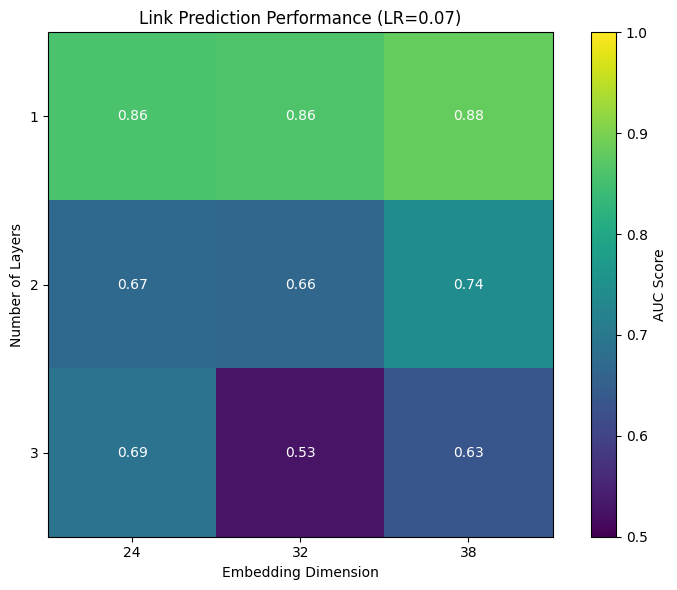

In [10]:
# Plot for GraphSAGE
import matplotlib.pyplot as plt
import numpy as np

fixed_lr = 0.07  # Choose a fixed learning rate for the plot
plt.figure(figsize=(8, 6))

# Extract scores for chosen learning rate
a = np.array([[graphsage_auc_scores[(ed, nl, fixed_lr)] 
                for ed in embedding_dims] 
                for nl in num_layers_list])

# Create heatmap
heatmap = plt.imshow(a, cmap="viridis", interpolation="nearest", vmin=0.5, vmax=1.0)
plt.colorbar(heatmap, label="AUC Score")

# Axis labels and ticks
plt.xticks(ticks=range(len(embedding_dims)), 
           labels=[str(d) for d in embedding_dims])
plt.xlabel("Embedding Dimension")

plt.yticks(ticks=range(len(num_layers_list)), 
           labels=[str(n) for n in num_layers_list])
plt.ylabel("Number of Layers")

plt.title(f"Link Prediction Performance (LR={fixed_lr})")

# Add text annotations for the AUC scores
for i in range(len(num_layers_list)):
    for j in range(len(embedding_dims)):
        plt.text(j, i, f"{a[i, j]:.2f}", ha='center', va='center', color='white')

plt.tight_layout()
plt.savefig(f"graphsage_auc_scores_lr_{fixed_lr}.png")
plt.show()

In [11]:
import torch
from torch_geometric.nn import LGConv

class LightGCN(torch.nn.Module):
    def __init__(self, num_nodes, embedding_dim, num_layers=3):
        super().__init__()
        self.embedding = Embedding(num_nodes,embedding_dim)# TODO
        self.convs = torch.nn.ModuleList([LGConv() for _ in range(num_layers)])
        self.num_layers = num_layers


    def forward(self, x, edge_index):
        x = self.embedding(x)
        out = x / (self.num_layers + 1)  # Initial contribution
        
        for conv in self.convs:
            # TODO
            out = conv(out,edge_index)

        return out

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.lin = torch.nn.Linear(2*in_dim, 1)# TODO

    def forward(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        return self.lin(torch.cat([src, dst], dim=1)).squeeze()


In [12]:
# Move data to device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [13]:
from tqdm import tqdm

embedding_dims = [16,32,48] # TODO
num_layers_list = [1,2, 3] # TODO
lr_list = [0.1, 0.2]# TODO
# Move data to device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
lightgcn_auc_scores = {}
verbose = False
for embedding_dim in embedding_dims:
    for num_layers in num_layers_list:
        for lr in lr_list:
            print(f"emd: {embedding_dim}, layers: {num_layers}, lr: {lr}")
            # Initialize model with current parameters
            model = LightGCN(
                num_nodes=train_data.num_nodes,
                embedding_dim=embedding_dim,
                num_layers=num_layers  # Modified to accept layer count
            ).to(device)

            predictor = LinkPredictor(in_dim=embedding_dim).to(device)
            optimizer = torch.optim.Adam(
                list(model.parameters()) + list(predictor.parameters()),
                lr=lr
            )
            # Training loop
            for epoch in tqdm(range(1, 20)):
                loss = train(model, predictor, optimizer)
                val_loss, val_auc, val_precision, val_recall, val_f1 = test(model, predictor, val_data)
                test_loss, test_auc, test_precision, test_recall, test_f1 = test(model, predictor, test_data)
                if verbose:
                    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
                    print(f'Validation - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
                    print(f'Test - Loss: {test_loss:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
                    print('-' * 80)  # Separator line for better readability
                
            _, test_auc, _, _, test_f1 = test(model, predictor, test_data)
            lightgcn_auc_scores[(embedding_dim, num_layers, lr)] = test_auc

            torch.cuda.empty_cache()
            print(f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

emd: 16, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Allocated: 0.16 GB
emd: 16, layers: 1, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  2.04it/s]


Allocated: 0.16 GB
emd: 16, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


Allocated: 0.16 GB
emd: 16, layers: 2, lr: 0.2


100%|██████████| 19/19 [00:12<00:00,  1.54it/s]


Allocated: 0.16 GB
emd: 16, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


Allocated: 0.16 GB
emd: 16, layers: 3, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  2.01it/s]


Allocated: 0.16 GB
emd: 32, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:12<00:00,  1.54it/s]


Allocated: 0.21 GB
emd: 32, layers: 1, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Allocated: 0.21 GB
emd: 32, layers: 2, lr: 0.2


100%|██████████| 19/19 [00:12<00:00,  1.53it/s]


Allocated: 0.21 GB
emd: 32, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Allocated: 0.21 GB
emd: 32, layers: 3, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Allocated: 0.21 GB
emd: 48, layers: 1, lr: 0.1


100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


Allocated: 0.26 GB
emd: 48, layers: 1, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Allocated: 0.26 GB
emd: 48, layers: 2, lr: 0.1


100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Allocated: 0.26 GB
emd: 48, layers: 2, lr: 0.2


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Allocated: 0.26 GB
emd: 48, layers: 3, lr: 0.1


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


Allocated: 0.26 GB
emd: 48, layers: 3, lr: 0.2


100%|██████████| 19/19 [00:10<00:00,  1.84it/s]

Allocated: 0.26 GB


## Plot for LightGCN

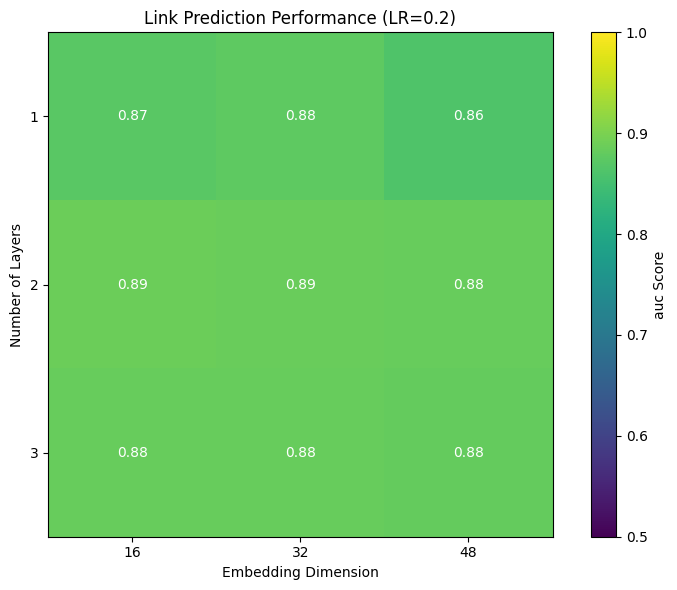

In [14]:
# Plot for LightGCN
import matplotlib.pyplot as plt
import numpy as np

fixed_lr = 0.2  # Choose a fixed learning rate for the plot
plt.figure(figsize=(8, 6))

# Extract scores for chosen learning rate
a = np.array([[lightgcn_auc_scores[(ed, nl, fixed_lr)] 
                for ed in embedding_dims] 
                for nl in num_layers_list])

# Create heatmap
heatmap = plt.imshow(a, cmap="viridis", interpolation="nearest", vmin=0.5, vmax=1.0)
plt.colorbar(heatmap, label="auc Score")

# Axis labels and ticks
plt.xticks(ticks=range(len(embedding_dims)), 
           labels=[str(d) for d in embedding_dims])
plt.xlabel("Embedding Dimension")

plt.yticks(ticks=range(len(num_layers_list)), 
           labels=[str(n) for n in num_layers_list])
plt.ylabel("Number of Layers")

plt.title(f"Link Prediction Performance (LR={fixed_lr})")

# Add text annotations for the AUC scores
for i in range(len(num_layers_list)):
    for j in range(len(embedding_dims)):
        plt.text(j, i, f"{a[i, j]:.2f}", ha='center', va='center', color='white')

plt.tight_layout()
plt.savefig(f"lightgcn_auc_scores_lr_{fixed_lr}.png")
plt.show()

## Export Model Weights For Submission

In [15]:
torch_geometric.seed_everything(4332)

# Put your best model configs here
model = GraphSAGE(
                num_nodes=train_data.num_nodes,
                embedding_dim=38 ,# TODO
                hidden_dim=256,  # Fixed hidden dimension
                out_dim=256,
                num_layers=1  # TODO
            ).to(device)

predictor = LinkPredictor(in_dim=256).to(device)
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()),
    lr=0.07 # TODO
)
# Training loop
verbose = False
for epoch in tqdm(range(1, 20)):
    loss = train(model, predictor, optimizer)
    val_loss, val_auc, val_precision, val_recall, val_f1 = test(model, predictor, val_data)
    test_loss, test_auc, test_precision, test_recall, test_f1 = test(model, predictor, test_data)
    if verbose:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
        print(f'Test - Loss: {test_loss:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
        print('-' * 80)  # Separator line for better readability
    
_, test_auc, _, _, _ = test(model, predictor, test_data)
print(f"GraphSAGE Test AUC: {test_auc:.4f}")
torch.save(model.state_dict(), "best_graphsage_model.pth")

model = LightGCN(
                num_nodes=train_data.num_nodes,
                embedding_dim=16, # TODO
                num_layers=2  # TODO
            ).to(device)

predictor = LinkPredictor(in_dim=16).to(device)
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()),
    lr=0.2 # TODO
)
# Training loop
for epoch in tqdm(range(1, 20)):
    loss = train(model, predictor, optimizer)
    val_loss, val_auc, val_precision, val_recall, val_f1 = test(model, predictor, val_data)
    test_loss, test_auc, test_precision, test_recall, test_f1 = test(model, predictor, test_data)
    if verbose:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
        print(f'Test - Loss: {test_loss:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
        print('-' * 80)  # Separator line for better readability
    
_, test_auc, _, _, test_f1 = test(model, predictor, test_data)
print(f"LightGCN Test AUC: {test_auc:.4f}")
torch.save(model.state_dict(), "best_lightgcn_model.pth")


100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


GraphSAGE Test AUC: 0.8801


100%|██████████| 19/19 [00:12<00:00,  1.49it/s]

LightGCN Test AUC: 0.8851
